# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [5]:
from kan import *

# initialize KAN with G=3
model = KAN(width=[2,1,1], grid=3, k=3)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
print(dataset.keys())

dict_keys(['train_input', 'test_input', 'train_label', 'test_label'])


Train KAN (grid=3)

In [2]:
model.train(dataset, opt="LBFGS", steps=20);

train loss: 1.53e-02 | test loss: 1.48e-02 | reg: 3.04e+00 : 100%|██| 20/20 [00:02<00:00,  6.86it/s]


The loss plateaus. we want a more fine-grained KAN!

In [6]:
# initialize a more fine-grained KAN with G=10
model2 = KAN(width=[2,1,1], grid=10, k=3)
# initialize model2 from model
model2.initialize_from_another_model(model, dataset['train_input']);

Train KAN (grid=10)

In [7]:
model2.train(dataset, opt="LBFGS", steps=20);

train loss: 2.24e-03 | test loss: 1.83e-03 | reg: 2.72e+00 : 100%|██| 20/20 [00:03<00:00,  6.25it/s]


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

In [8]:
grids = np.array([5,10,20,50,100])

train_losses = []
test_losses = []
steps = 50
k = 3

for i in range(grids.shape[0]):
    if i == 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k)
    if i != 0:
        model = KAN(width=[2,1,1], grid=grids[i], k=k).initialize_from_another_model(model, dataset['train_input'])
    results = model.train(dataset, opt="LBFGS", steps=steps, stop_grid_update_step=30)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

train loss: 6.66e-03 | test loss: 6.71e-03 | reg: 2.83e+00 : 100%|██| 50/50 [00:07<00:00,  7.01it/s]
train loss: 3.24e-04 | test loss: 3.33e-04 | reg: 2.84e+00 : 100%|██| 50/50 [00:07<00:00,  6.28it/s]
train loss: 1.98e-05 | test loss: 2.13e-05 | reg: 2.85e+00 : 100%|██| 50/50 [00:08<00:00,  5.63it/s]
train loss: 1.10e-06 | test loss: 1.61e-06 | reg: 2.85e+00 : 100%|██| 50/50 [00:12<00:00,  3.97it/s]
train loss: 2.23e-07 | test loss: 9.34e-07 | reg: 2.85e+00 : 100%|██| 50/50 [00:15<00:00,  3.17it/s]


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

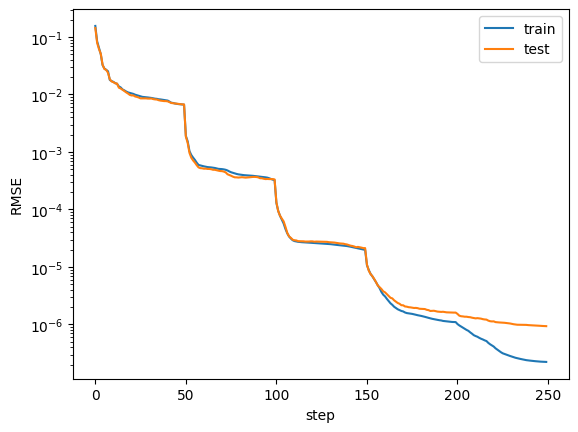

In [9]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws

[ 15  30  60 150 300]


Text(0, 0.5, 'RMSE')

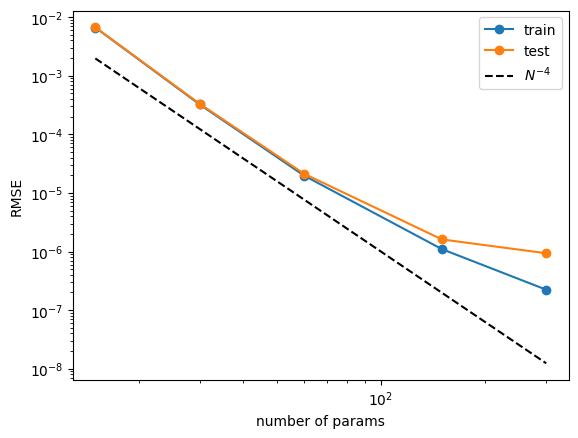

In [10]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')